In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Load Libraries
import pandas
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression, SelectFromModel
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn import datasets
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot
from sklearn.datasets import make_classification
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RepeatedKFold, learning_curve
from sklearn.svm import SVR
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X_train = pandas.read_csv(r'/content/drive/My Drive/CMPS_276/final_data/X_train.csv')
y_train = pandas.read_csv(r'/content/drive/My Drive/CMPS_276/final_data/Y_train.csv')
X_test = pandas.read_csv(r'/content/drive/My Drive/CMPS_276/final_data/X_test.csv')
y_test = pandas.read_csv(r'/content/drive/My Drive/CMPS_276/final_data/Y_test.csv')

In [ ]:
X_train = X_train.iloc[: , 1:]
y_train = y_train.iloc[: , 1:]
X_test = X_test.iloc[: , 1:]
y_test = y_test.iloc[:,1:]

In [ ]:
# Include only the numeric columns in the data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_train_numerical_colnames = list(X_train.select_dtypes(include=numerics).columns)
X_test_numerical_colnames = list(X_test.select_dtypes(include=numerics).columns)
y_train_numerical_colnames = list(y_train.select_dtypes(include=numerics).columns)
X_train = X_train[X_train_numerical_colnames]
y_train = y_train[y_train_numerical_colnames]
X_test = X_test[X_test_numerical_colnames]

print(X_train.shape)
print(y_train.shape)

(69809, 31)
(69809, 1)


# Feature Importance - XGBoost

[19:32:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


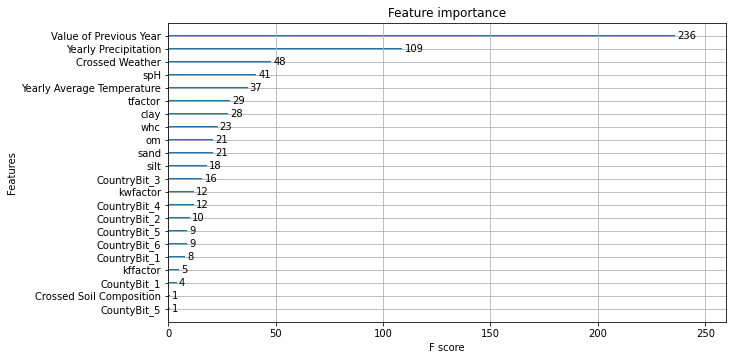

In [ ]:
from xgboost import XGBRegressor
import xgboost as xgb
# initialize the model
model_xgb = XGBRegressor()
# train the model
model_xgb.fit(X_train.fillna(0), y_train)
# use plot_importance() to plot the feature importances
xgb.plot_importance(model_xgb)
fig = plt.gcf()
fig.set_size_inches(10, 5.5)

#Feature Importance - Extra Trees

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


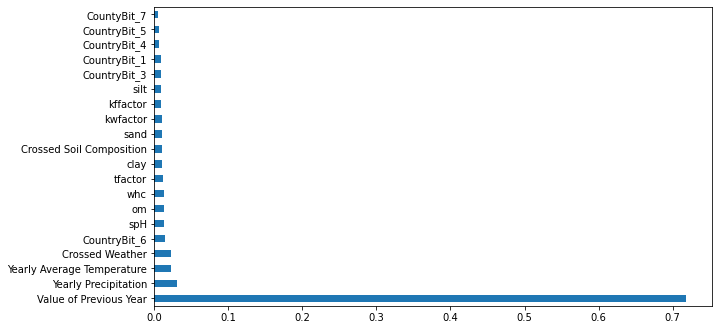

In [ ]:
# Initialize the model
model_et = ExtraTreesRegressor(n_estimators=100, random_state=42)
# train the model
model_et.fit(X_train.fillna(0), y_train)
# Plot the feature importance scores. 
feat_importances = pd.Series(model_et.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
fig = plt.gcf()
fig.set_size_inches(10, 5.5)

#Feature Selection with XGBoost and Extra Trees's Feature Importance Scores 


In [ ]:
# Initialize a SelectFromModel instance on the trained Extra Trees model
selection = SelectFromModel(model_et, prefit=True)

# Transform X_train and X_test into subsets of the selected features only
select_X_train = selection.transform(X_train.fillna(0))
select_X_test = selection.transform(X_test.fillna(0))

# Initiale a new Extra Trees model and train it on the new subsets created above
selection_model = ExtraTreesRegressor()
selection_model.fit(select_X_train, y_train)

# evaluate the predictions of the model on the testing (new subset above) using MAE
y_pred = selection_model.predict(select_X_test)
mae = mean_absolute_error(y_test, y_pred)
print('MAE: {:.5f}'.format(mae))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


MAE: 6.00857


#Univariate Feature Selection

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


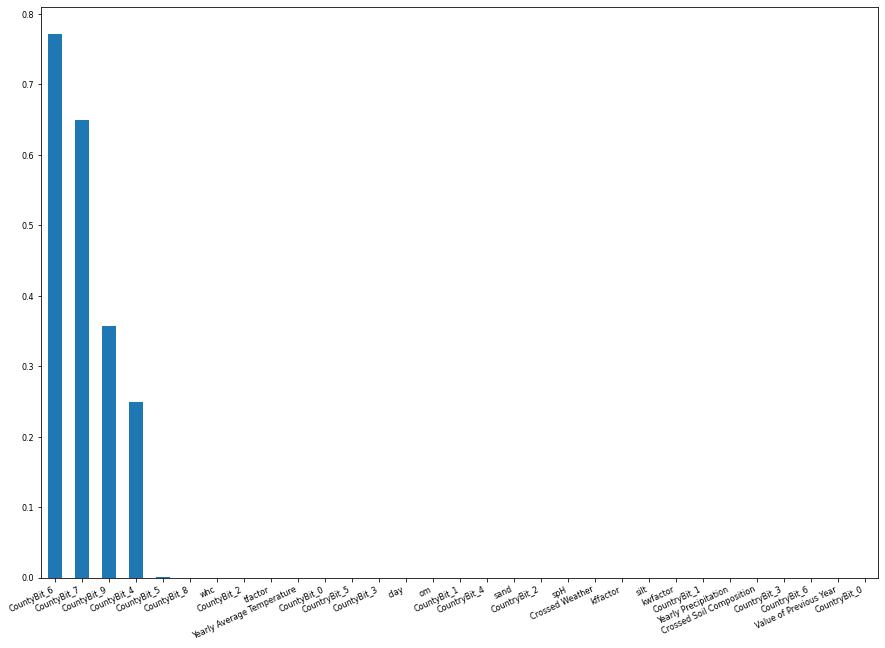

In [ ]:
# calculate the univariate statistical measure between
# each of the variables and the target
# the output is an array of f-statistic scores and an array of pvalues, which are the ones we will compare
univariate = f_regression(X_train.fillna(0), y_train)
univariate = pd.Series(univariate[1])
univariate.index = X_train.columns
univariate.sort_values(ascending=False).plot.bar()
plt.xticks(rotation=25, ha="right", fontsize=8)
plt.yticks(fontsize=8)
fig = plt.gcf()
fig.set_size_inches(15, 10.5)

#Recursive Feature Elimination

In [ ]:
feature_names = [col for col in X_train.columns]
estimator = DecisionTreeRegressor()
selector = RFE(estimator)
fit = selector.fit(X_train.fillna(0), y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
selected = []
for i in range(len(fit.support_)):
    if fit.support_[i]:
        selected.append(feature_names[i])
print('Selected Features: ', selected)

Num Features: 15
Selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False  True False False False False False
 False False False False False False False]
Feature Ranking: [ 1  1  1  1  1  1  1  1  1  1  1  1  1  1 17  8 13  2  1  3  4 16 14  9
 12 10  7 11  5  6 15]
Selected Features:  ['whc', 'sand', 'silt', 'clay', 'om', 'kwfactor', 'kffactor', 'spH', 'tfactor', 'Yearly Precipitation', 'Yearly Average Temperature', 'Value of Previous Year', 'Crossed Soil Composition', 'Crossed Weather', 'CountryBit_4']


#Principal Component Analysis

In [11]:
for i in range(1, 21):
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train.fillna(0))
    X_test_pca = pca.transform(X_test.fillna(0))
    
    cv = RepeatedKFold(n_splits=10, n_repeats=10)
    scores = cross_val_score(DecisionTreeRegressor(), X_train_pca, y_train, 
                              cv=cv, scoring='neg_mean_absolute_error')
    
    print('PCA nb of components: {} - MAE: {:.3f} ({:.3f})'.format(i, np.mean(scores), np.std(scores)))

PCA nb of components: 1 - MAE: -16.123 (0.161)
PCA nb of components: 2 - MAE: -14.194 (0.127)
PCA nb of components: 3 - MAE: -9.731 (0.095)
PCA nb of components: 4 - MAE: -9.252 (0.083)
PCA nb of components: 5 - MAE: -8.258 (0.075)
PCA nb of components: 6 - MAE: -8.053 (0.079)
PCA nb of components: 7 - MAE: -7.999 (0.087)
PCA nb of components: 8 - MAE: -8.018 (0.085)
PCA nb of components: 9 - MAE: -8.038 (0.078)
PCA nb of components: 10 - MAE: -8.043 (0.081)
PCA nb of components: 11 - MAE: -8.047 (0.079)
PCA nb of components: 12 - MAE: -8.056 (0.075)
PCA nb of components: 13 - MAE: -8.061 (0.085)
PCA nb of components: 14 - MAE: -8.025 (0.088)
PCA nb of components: 15 - MAE: -8.017 (0.082)
PCA nb of components: 16 - MAE: -8.012 (0.080)
PCA nb of components: 17 - MAE: -7.996 (0.091)
PCA nb of components: 18 - MAE: -7.987 (0.090)
PCA nb of components: 19 - MAE: -7.982 (0.078)
PCA nb of components: 20 - MAE: -7.978 (0.078)


#Select KBest Mutual information Regression

In [ ]:
best_features = SelectKBest(score_func=mutual_info_regression, k='all')
fit = best_features.fit(X_train,y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # name output columns
print(feature_scores.nlargest(20,'Score'))  # print 20 best features

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


                  Feature_Name     Score
11      Value of Previous Year  0.780918
7                          spH  0.150086
2                         silt  0.124292
1                         sand  0.100419
6                     kffactor  0.098425
5                     kwfactor  0.097006
12    Crossed Soil Composition  0.092444
3                         clay  0.083981
4                           om  0.076942
10  Yearly Average Temperature  0.076390
0                          whc  0.074928
8                      tfactor  0.072716
9         Yearly Precipitation  0.069528
20                CountryBit_6  0.047312
13             Crossed Weather  0.039356
17                CountryBit_3  0.039332
15                CountryBit_1  0.035441
19                CountryBit_5  0.034164
16                CountryBit_2  0.028693
22                 CountyBit_1  0.013455
